In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
os.listdir('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train')

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
from sklearn.utils import shuffle
DATA=[]
for main_ in ['train', 'test']:
  for i,folder in enumerate(os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}')):
    for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}/{folder}'):
      img=cv2.imread(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}/{folder}/{image}')
      img=cv2.resize(img,(128,128))/255.0
      DATA.append((img,i))
DATA=np.array(shuffle(DATA))

<ipython-input-4-feccfdeadbf8>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


In [ ]:
DATA.shape

(6400, 2)

In [ ]:
Images=np.array([i for i in DATA[:,0]]).reshape((6400,128,128,3))
Labels=DATA[:,1].astype(np.float32)
x_train,x_test,y_train,y_test=Images[:5600],Images[5600:],Labels[:5600],Labels[5600:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((5600, 128, 128, 3), (800, 128, 128, 3), (5600,), (800,))

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,4)
y_test=to_categorical(y_test,4)
y_train.shape

(5600, 4)

## Models

## Convolutional Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder_1")(encoder_flatten)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder_1)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(4,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
175/175 [==============================] - 27s 44ms/step - loss: 2.1987 - decoder_model_loss: 0.0633 - classifier_loss: 2.1354 - decoder_model_mae: 0.1608 - classifier_categorical_accuracy: 0.6482 - classifier_recall: 0.7212 - classifier_precision: 0.4064 - classifier_get_f1: 0.5272 - classifier_auc: 0.7410 - val_loss: 1.6198 - val_decoder_model_loss: 0.0467 - val_classifier_loss: 1.5731 - val_decoder_model_mae: 0.1452 - val_classifier_categorical_accuracy: 0.5350 - val_classifier_recall: 0.5362 - val_classifier_precision: 0.5356 - val_classifier_get_f1: 0.5358 - val_classifier_auc: 0.6570
Epoch 2/10
175/175 [==============================] - 5s 30ms/step - loss: 0.5427 - decoder_model_loss: 0.0209 - classifier_loss: 0.5218 - decoder_model_mae: 0.0961 - classifier_categorical_accuracy: 0.8330 - classifier_recall: 0.9000 - classifier_precision: 0.5846 - classifier_get_f1: 0.7108 - classifier_auc: 0.9089 - val_loss: 1.1140 - val_decoder_model_loss: 0.0206 - val_classifier_loss

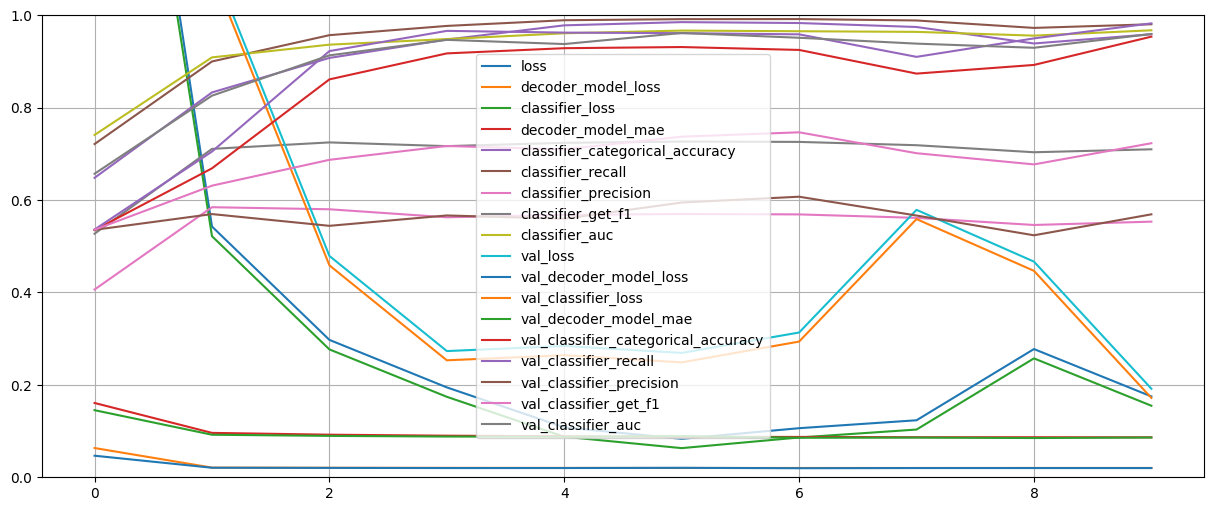

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
del decoder

In [ ]:
import seaborn as sns
encoded=encoder(x_test[:1000]).numpy()
class_names=np.array(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])


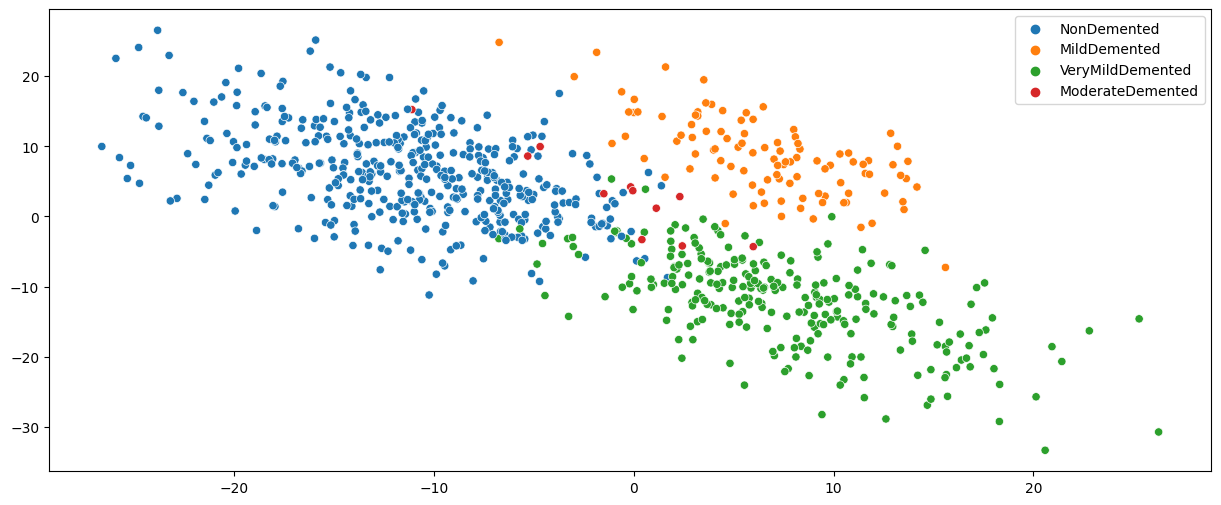

In [ ]:
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test[:1000], axis=1)])
plt.savefig('Conv_AE_Out.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

x_test_sampled = x_test[:1000, :]
y_test_sampled = y_test[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.savefig('Conv_AE_TSNE.pdf')

## Variational Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")










import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )


decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(4,activation='sigmoid', name='classifier')(vae.get_layer('encoder_output').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
175/175 [==============================] - 28s 47ms/step - loss: 1.6726 - decoder_model_loss: 0.0447 - classifier_loss: 1.6279 - decoder_model_mae: 0.1313 - classifier_categorical_accuracy: 0.6171 - classifier_recall: 0.4032 - classifier_precision: 0.5718 - classifier_get_f1: 0.4740 - classifier_auc: 0.7855 - val_loss: 1.1443 - val_decoder_model_loss: 0.0418 - val_classifier_loss: 1.1025 - val_decoder_model_mae: 0.1476 - val_classifier_categorical_accuracy: 0.4600 - val_classifier_recall: 0.0063 - val_classifier_precision: 1.0000 - val_classifier_get_f1: 0.0121 - val_classifier_auc: 0.7305
Epoch 2/10
175/175 [==============================] - 6s 35ms/step - loss: 0.4929 - decoder_model_loss: 0.0204 - classifier_loss: 0.4724 - decoder_model_mae: 0.0905 - classifier_categorical_accuracy: 0.8070 - classifier_recall: 0.4702 - classifier_precision: 0.5724 - classifier_get_f1: 0.5123 - classifier_auc: 0.8546 - val_loss: 0.6738 - val_decoder_model_loss: 0.0247 - val_classifier_loss

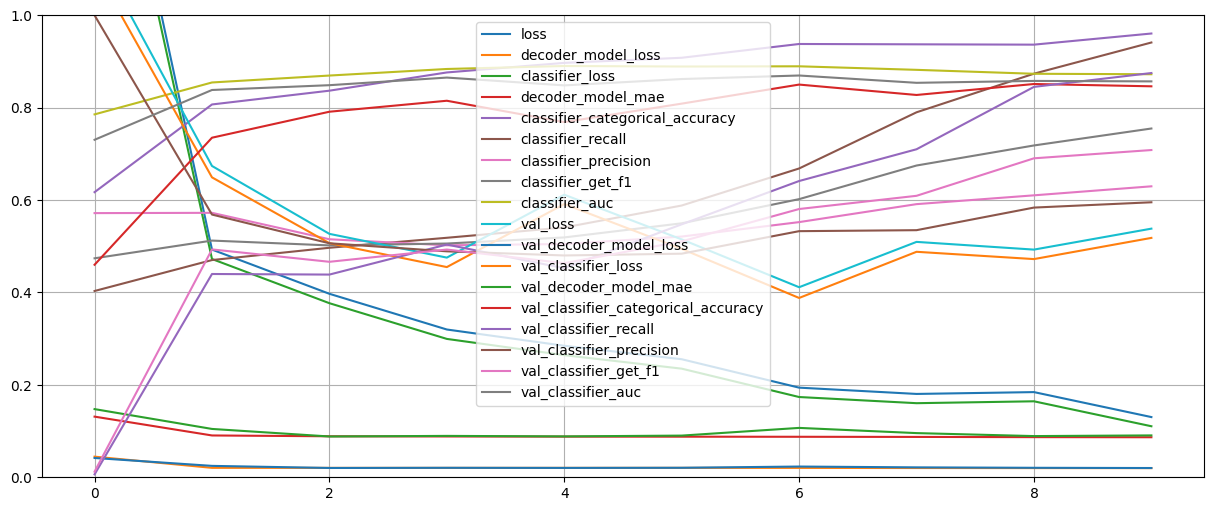

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig('VAE_Curves.png')
plt.show()

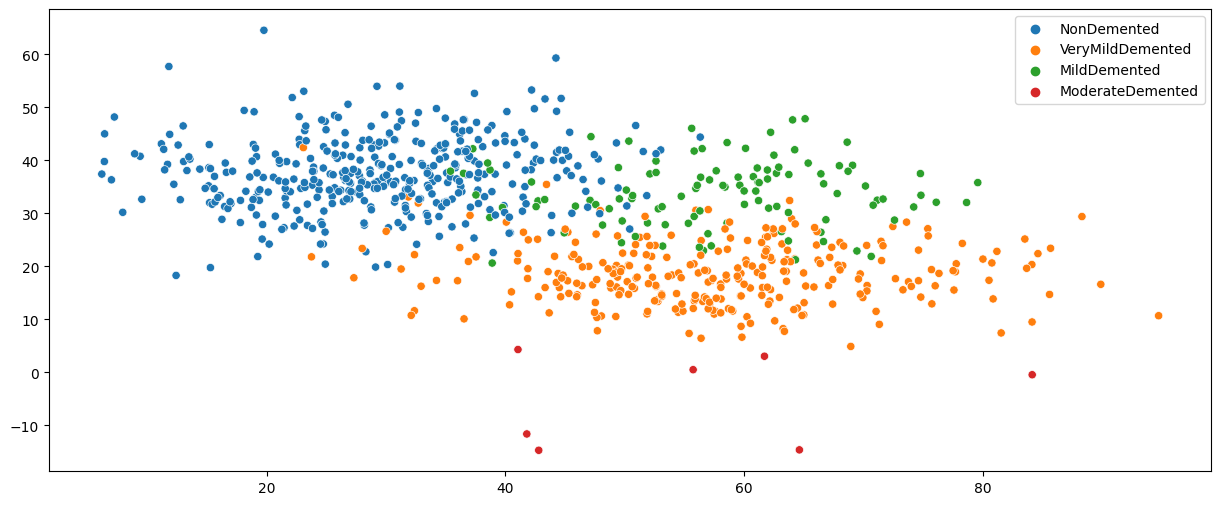

In [ ]:
import seaborn as sns
encoded=encoder(x_test).numpy()
class_names=np.array(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test, axis=1)])
plt.savefig('VAE_Clusters.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

x_test_sampled = x_test[:1000, :]
y_test_sampled = y_test[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(800, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')

## Sparse Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder_1")(encoder_flatten)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder_1)
encoder_flatten= tensorflow.keras.layers.ActivityRegularization(l1=1e-3, name='reg')(encoder_2)

encoder = tensorflow.keras.models.Model(x, encoder_flatten, name="encoder_model")


import numpy
from tensorflow import keras
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(4,activation='sigmoid', name='classifier')(vae.get_layer('reg').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
175/175 [==============================] - 30s 54ms/step - loss: 1.7393 - decoder_model_loss: 0.0549 - classifier_loss: 1.6739 - decoder_model_mae: 0.1493 - classifier_categorical_accuracy: 0.6043 - classifier_recall: 0.8173 - classifier_precision: 0.3266 - classifier_get_f1: 0.4688 - classifier_auc: 0.6787 - val_loss: 1.3212 - val_decoder_model_loss: 0.0485 - val_classifier_loss: 1.2704 - val_decoder_model_mae: 0.1679 - val_classifier_categorical_accuracy: 0.4800 - val_classifier_recall: 0.6812 - val_classifier_precision: 0.2239 - val_classifier_get_f1: 0.3371 - val_classifier_auc: 0.6147
Epoch 2/10
175/175 [==============================] - 7s 40ms/step - loss: 0.2957 - decoder_model_loss: 0.0216 - classifier_loss: 0.2613 - decoder_model_mae: 0.0964 - classifier_categorical_accuracy: 0.9202 - classifier_recall: 0.9804 - classifier_precision: 0.4103 - classifier_get_f1: 0.5797 - classifier_auc: 0.8199 - val_loss: 0.7020 - val_decoder_model_loss: 0.0228 - val_classifier_loss

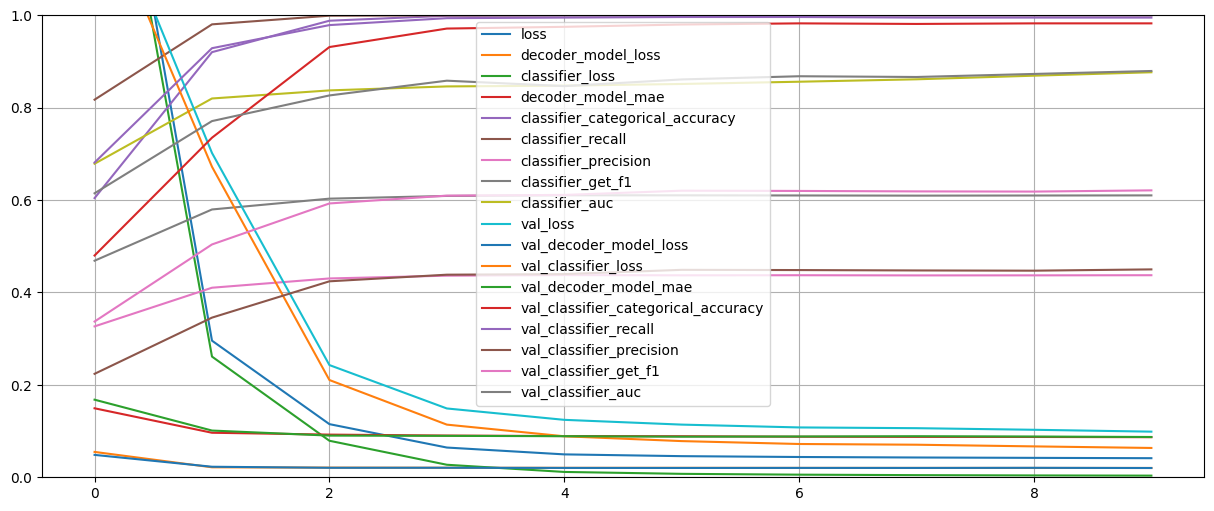

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig('SAE_Curves.png')
plt.show()

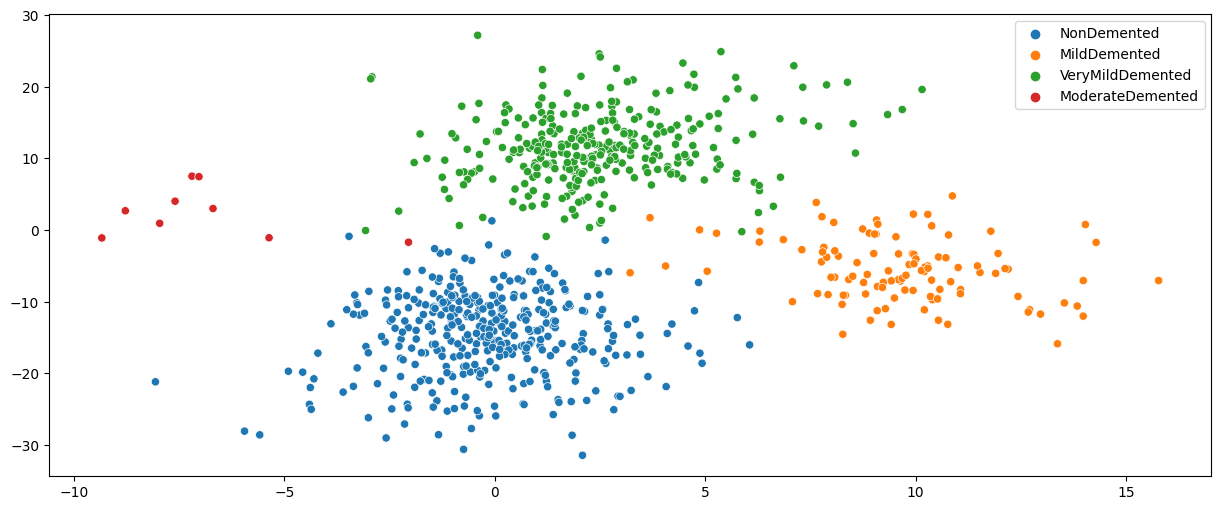

In [ ]:
import seaborn as sns
encoded=encoder(x_test).numpy()
class_names=np.array(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test, axis=1)])
plt.savefig('SAE_Clusters.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

X_test_sampled = x_test[:1000, :]
y_test_sampled = y_test.iloc[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoder.predict(x_test_sampled).mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
X_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')

## Contractive Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder_1")(encoder_flatten)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder_1)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(4,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

lam=100
def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)
    W = K.variable(value=encoder.get_layer('encoder_2').get_weights()[0])  
    W = K.transpose(W)
    h = encoder.get_layer('encoder_2').output
    dh = h * (1 - h)
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1) #uses the last formula
    return mse + contractive #returns total loss calculated


MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':contractive_loss, 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))


In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig('CAE_Curves.png')
plt.show()

In [ ]:
import seaborn as sns
encoded=encoder(x_test).numpy()
class_names=np.array(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test, axis=1)])
plt.savefig('CAE_Clusters.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

X_test_sampled = x_test[:1000, :]
y_test_sampled = y_test.iloc[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoder.predict(x_test_sampled).mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
X_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')

## Under Autoencoder

In [ ]:
import tensorflow
latent_space_dim=64
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*3, name="encoder_1")(encoder_flatten)
encoder__ = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder__")(encoder_1)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder__)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(4,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
175/175 [==============================] - 29s 48ms/step - loss: 3.3868 - decoder_model_loss: 0.0528 - classifier_loss: 3.3340 - decoder_model_mae: 0.1356 - classifier_categorical_accuracy: 0.5100 - classifier_recall: 0.9866 - classifier_precision: 0.3390 - classifier_get_f1: 0.5046 - classifier_auc: 0.6991 - val_loss: 0.9588 - val_decoder_model_loss: 0.0741 - val_classifier_loss: 0.8847 - val_decoder_model_mae: 0.1955 - val_classifier_categorical_accuracy: 0.6775 - val_classifier_recall: 0.9262 - val_classifier_precision: 0.4298 - val_classifier_get_f1: 0.5872 - val_classifier_auc: 0.8243
Epoch 2/10
175/175 [==============================] - 6s 34ms/step - loss: 0.1499 - decoder_model_loss: 0.0155 - classifier_loss: 0.1344 - decoder_model_mae: 0.0784 - classifier_categorical_accuracy: 0.9046 - classifier_recall: 0.9995 - classifier_precision: 0.3539 - classifier_get_f1: 0.5230 - classifier_auc: 0.7588 - val_loss: 0.4262 - val_decoder_model_loss: 0.0416 - val_classifier_loss

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
encoded=encoder(x_test).numpy()
x_test_sampled = x_test[:, :]
y_test_sampled = y_test[:]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(800, -1)


In [ ]:
x_compressed.shape

(800, 1)

<ipython-input-18-3e673d849a2e>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)


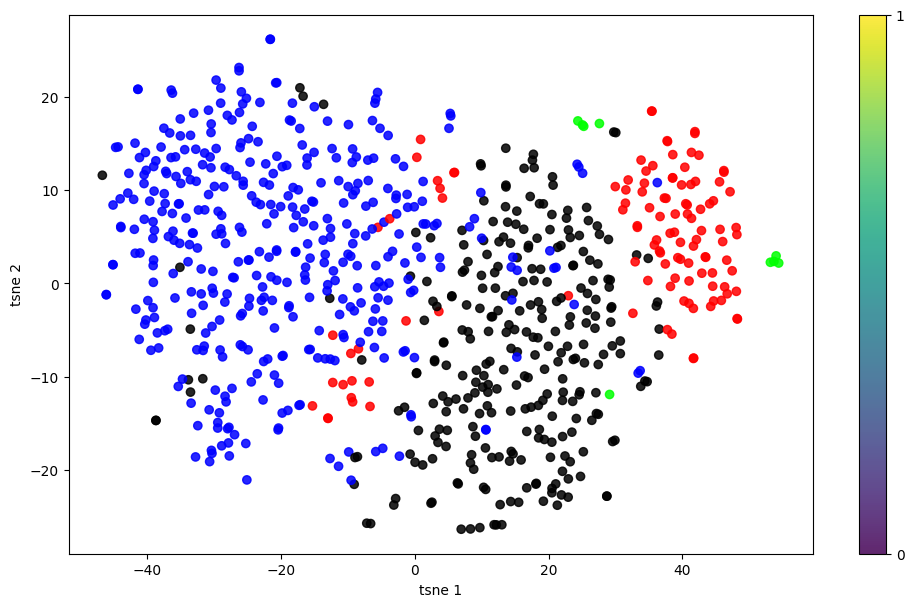

In [ ]:
# Use TSNE
tsne = TSNE(n_components=2,n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(encoded)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.savefig('Under_AE_TSNE.pdf')

## Overcomplete Autoencoder

In [ ]:
import tensorflow
latent_space_dim=128
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=32, name="encoder_1")(encoder_flatten)
encoder__ = tensorflow.keras.layers.Dense(units=64, name="encoder__")(encoder_1)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder__)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(4,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
175/175 [==============================] - 30s 47ms/step - loss: 1.4984 - decoder_model_loss: 0.0454 - classifier_loss: 1.4529 - decoder_model_mae: 0.1337 - classifier_categorical_accuracy: 0.6762 - classifier_recall: 0.9400 - classifier_precision: 0.4039 - classifier_get_f1: 0.5699 - classifier_auc: 0.7976 - val_loss: 0.9823 - val_decoder_model_loss: 0.0777 - val_classifier_loss: 0.9046 - val_decoder_model_mae: 0.2074 - val_classifier_categorical_accuracy: 0.5475 - val_classifier_recall: 0.8850 - val_classifier_precision: 0.4381 - val_classifier_get_f1: 0.5860 - val_classifier_auc: 0.8622
Epoch 2/10
175/175 [==============================] - 6s 36ms/step - loss: 0.2440 - decoder_model_loss: 0.0155 - classifier_loss: 0.2285 - decoder_model_mae: 0.0795 - classifier_categorical_accuracy: 0.9129 - classifier_recall: 0.9937 - classifier_precision: 0.4937 - classifier_get_f1: 0.6611 - classifier_auc: 0.9554 - val_loss: 0.8004 - val_decoder_model_loss: 0.0284 - val_classifier_loss

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
encoded=encoder(x_test).numpy()
x_test_sampled = x_test[:, :]
y_test_sampled = y_test[:]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(800, -1)


<ipython-input-11-158cba842eb0>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)


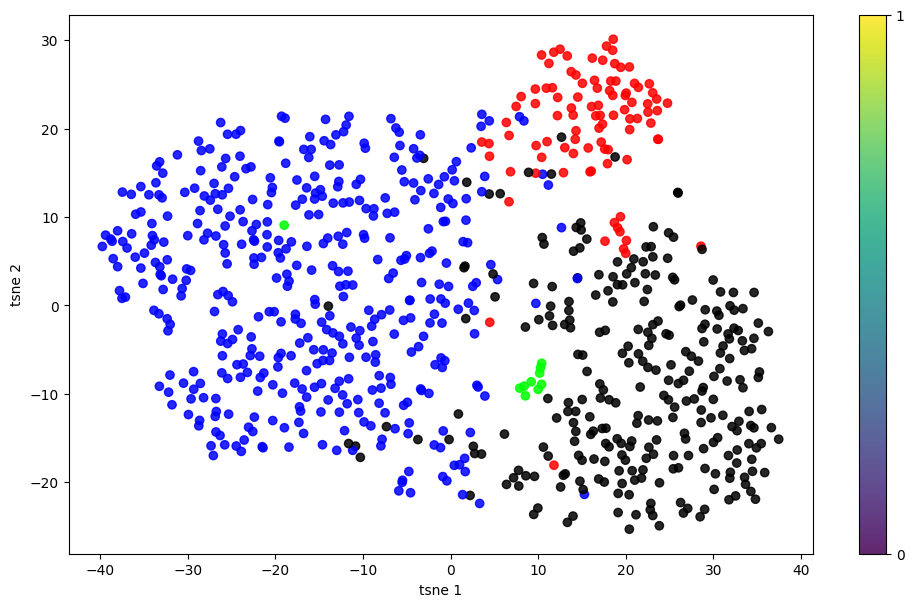

In [ ]:
# Use TSNE
tsne = TSNE(n_components=2,n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(encoded)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.savefig('Over_AE_TSNE.pdf')